In [45]:
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
import math

from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
from common.utils import load_data, mape

In [46]:
data_dir = '/Users/dmalea/Git-Project-V2/energy_client'
energy = load_data(data_dir)[['load']]
energy.head()

,load
2023-05-15 00:15:00,0.128
2023-05-15 00:30:00,0.128
2023-05-15 00:45:00,0.128
2023-05-15 01:00:00,0.112
2023-05-15 01:15:00,0.097


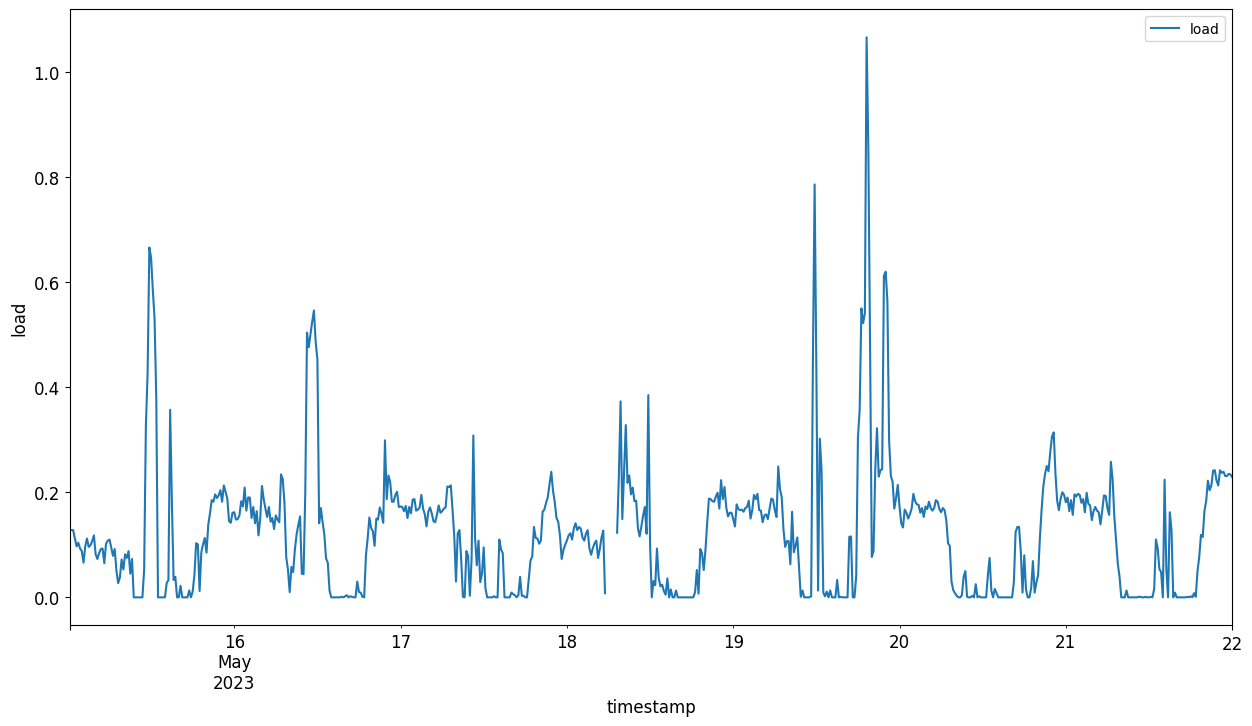

In [47]:
energy.plot(subplots=True, figsize=(15, 8), fontsize=12)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()

In [48]:
train_start_dt = '2023-05-15 00:15:00'
test_start_dt = '2023-05-20 12:00:00'

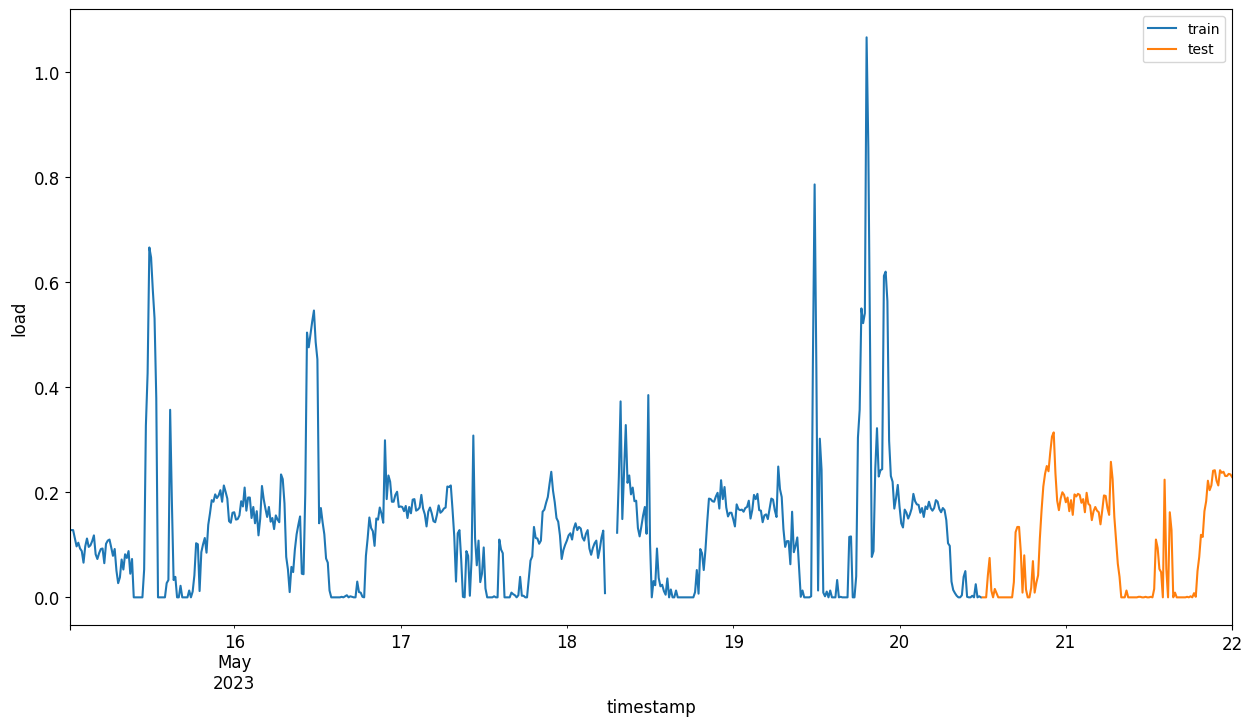

In [49]:
energy[(energy.index < test_start_dt) & (energy.index >= train_start_dt)][['load']].rename(columns={'load':'train'}) \
    .join(energy[test_start_dt:][['load']].rename(columns={'load':'test'}), how='outer') \
    .plot(y=['train', 'test'], figsize=(15, 8), fontsize=12)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()

In [50]:
# check how many null values
energy.isnull().values.sum()
energy = energy.interpolate()

In [51]:
train = energy.copy()[(energy.index >= train_start_dt) & (energy.index < test_start_dt)][['load']]
test = energy.copy()[energy.index >= test_start_dt][['load']]

print('Training data shape: ', train.shape)
print('Test data shape: ', test.shape)

Training data shape:  (527, 1)
Test data shape:  (145, 1)


In [52]:
scaler = MinMaxScaler()
train['load'] = scaler.fit_transform(train)

In [53]:
test['load'] = scaler.transform(test)

In [54]:
# Converting to numpy arrays
train_data = train.values
test_data = test.values

timesteps=5

train_data_timesteps=np.array([[j for j in train_data[i:i+timesteps]] for i in range(0,len(train_data)-timesteps+1)])[:,:,0]
train_data_timesteps.shape

(523, 5)

In [55]:
test_data_timesteps=np.array([[j for j in test_data[i:i+timesteps]] for i in range(0,len(test_data)-timesteps+1)])[:,:,0]
test_data_timesteps.shape

(141, 5)

In [56]:
x_train, y_train = train_data_timesteps[:,:timesteps-1],train_data_timesteps[:,[timesteps-1]]
x_test, y_test = test_data_timesteps[:,:timesteps-1],test_data_timesteps[:,[timesteps-1]]

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(523, 4) (523, 1)
(141, 4) (141, 1)


In [57]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')
x_train = imputer.fit_transform(x_train)
y_train = imputer.fit_transform(y_train)

model = SVR(kernel='rbf',gamma=0.7, C=60, epsilon = 0.07)
model.fit(x_train, y_train[:,0])
SVR(C=10, cache_size=200, coef0=0.0, degree=3, epsilon=0.05, gamma=0.5,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

SVR(C=10, epsilon=0.05, gamma=0.5)

In [58]:
y_train_pred = model.predict(x_train).reshape(-1,1)
y_test_pred = model.predict(x_test).reshape(-1,1)

print(y_train_pred.shape, y_test_pred.shape)

(523, 1) (141, 1)


In [59]:
# Scaling the predictions
y_train_pred = scaler.inverse_transform(y_train_pred)
y_test_pred = scaler.inverse_transform(y_test_pred)

print(len(y_train_pred), len(y_test_pred))

523 141


In [60]:
# Scaling the original values
y_train = scaler.inverse_transform(y_train)
y_test = scaler.inverse_transform(y_test)

print(len(y_train), len(y_test))

523 141


In [61]:
train_timestamps = energy[(energy.index < test_start_dt) & (energy.index >= train_start_dt)].index[timesteps-1:]
test_timestamps = energy[test_start_dt:].index[timesteps-1:]

print(len(train_timestamps), len(test_timestamps))

523 141


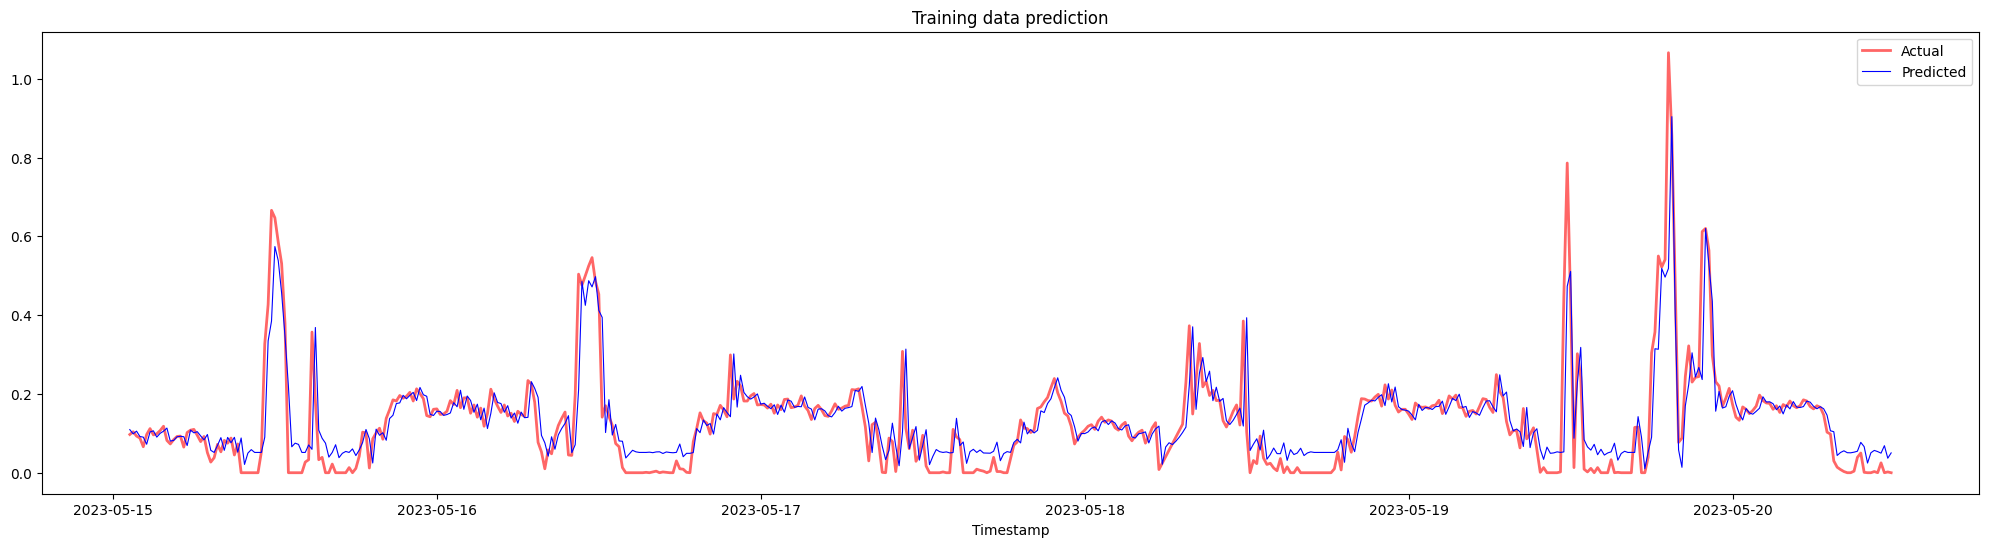

In [62]:
plt.figure(figsize=(25,6))
plt.plot(train_timestamps, y_train, color = 'red', linewidth=2.0, alpha = 0.6)
plt.plot(train_timestamps, y_train_pred, color = 'blue', linewidth=0.8)
plt.legend(['Actual','Predicted'])
plt.xlabel('Timestamp')
plt.title("Training data prediction")
plt.show()

In [63]:
print('MAPE for training data: ', mean_absolute_percentage_error(y_train_pred, y_train)*100, '%')

MAPE for training data:  46.24556512671107 %


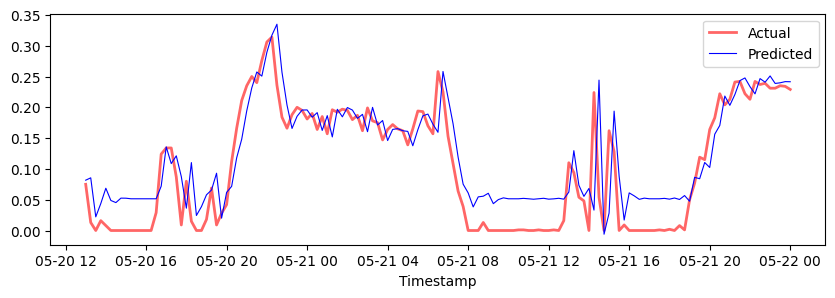

In [64]:
plt.figure(figsize=(10,3))
plt.plot(test_timestamps, y_test, color = 'red', linewidth=2.0, alpha = 0.6)
plt.plot(test_timestamps, y_test_pred, color = 'blue', linewidth=0.8)
plt.legend(['Actual','Predicted'])
plt.xlabel('Timestamp')
plt.show()

In [65]:
print('MAPE for testing data: ', mean_absolute_percentage_error(y_test_pred, y_test)*100, '%')

MAPE for testing data:  56.371180350050324 %
